<a href="https://colab.research.google.com/github/Anuraag20/CryptoAnomalyDetection/blob/master/Basic%20Exploration%20for%20the%20Anomaly%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Set - Up

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import os
import tensorflow as tf
# import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("We got a GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], False)
else:
    print("Sorry, no GPU for you...")

We got a GPU


I0000 00:00:1724236878.242224     824 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724236878.468325     824 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724236878.468406     824 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

NameError: name 'torch' is not defined

In [ ]:
ticker = yf.Ticker('BTC-USD')

In [ ]:
data = ticker.history(start = '2024-08-19', end = '2024-08-21', interval = '1m', auto_adjust = False)

data.index = data.index.tz_localize(None)

data

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,,
2024-08-19 00:00:00,58454.410156,58454.410156,58454.410156,58454.410156,58454.410156,0,0.0,0.0
2024-08-19 00:01:00,58453.476562,58453.476562,58453.476562,58453.476562,58453.476562,7976960,0.0,0.0
2024-08-19 00:02:00,58455.375000,58455.375000,58455.375000,58455.375000,58455.375000,7022592,0.0,0.0
2024-08-19 00:03:00,58490.679688,58490.679688,58490.679688,58490.679688,58490.679688,0,0.0,0.0
2024-08-19 00:04:00,58362.277344,58362.277344,58362.277344,58362.277344,58362.277344,6373376,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-08-20 23:54:00,59081.054688,59081.054688,59081.054688,59081.054688,59081.054688,0,0.0,0.0
2024-08-20 23:55:00,59065.777344,59065.777344,59065.777344,59065.777344,59065.777344,710656,0.0,0.0
2024-08-20 23:56:00,59051.277344,59051.277344,59051.277344,59051.277344,59051.277344,0,0.0,0.0


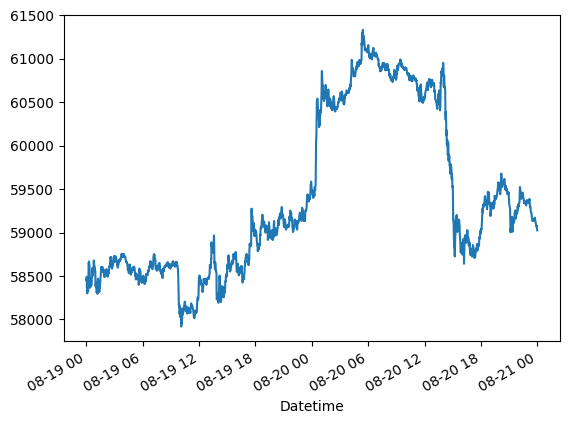

In [ ]:
_ = data['Close'].plot()

## Function Definitions

### Get Windowed DF

This function is more to just check what is happening to all the data when it is being windowed.

- data: The data that needs to be windowed.
- n: Number of previous datapoints to look at.
- vars: The columns to be considered while creating the windows.

Returns a dataframe

In [ ]:
def get_windowed_df(data, n = 30, vars = ['Close']):

    windowed = []

    for i in range(n, data.shape[0]):



        windowed.append([
            data.iloc[[i]].index[0], # Fetching the datetime
            data.iloc[i - n: i][vars].to_numpy(), # The 'n' previous close values
            data.iloc[i]['Close'] # The ith close value (Target)
        ])


    return pd.DataFrame(windowed, columns = [
        'datetime',
        f'previous_{n}_for_{vars}',
        'close'
    ])

### Get Windowed Data

This function is what returns the data that will be used to train/test the LSTM.

- data: The data that needs to be windowed.
- n: Number of previous datapoints to look at.
- vars: The columns to be considered while creating the windows.

Returns:
- List of datetime objects (index)
- Inputs for the model ('X')
- Ouputs for the model ('y')

In [ ]:
def get_windowed_data(X, y, dates, n = 30):

    times = []
    out_X = []
    out_y = []

    for i in range(n, X.shape[0]):

        out_X.append(
            X[i - n: i] # The 'n' previous values for the 'vars'
         )
        out_y.append(y[i])

    return dates[n:], np.array(out_X), np.array(out_y)

## Get Scaled Windowed 'X'

This function is not necessary, as the scaling is done BEFORE the data is windowed.

- X: The windowed features to be scaled.
- scalers: Pre-fit scalers that should be used on the features. If none, new ones are initialized.

Returns:
- The scaled feature values.
- Array of scalers used.

In [ ]:
def get_scaled_windowed_X(X, scalers = None):

    if scalers is None:

        scalers = np.repeat(MinMaxScaler(), X.shape[1])
        func_name = 'fit_transform'

    else:

        func_name = 'transform'

    for i in range(X.shape[1]):

            scaler = scalers[i]

            func = getattr(scaler, func_name)

            X[:, i, :] = func(X[:, i, :])

            scalers[i] = scaler


    return X, scalers

# Model Training (Tensorflow LSTM)

In [ ]:
TRAIN_IDX = round(0.8 * len(data))
VALIDATION_IDX = TRAIN_IDX + round(0.1 * len(data))
TEST_IDX = len(data) - 1
LOOKBACK_WINDOW = 15
FEATURES = ['Close', 'Open']

## Pre - Processing

In [ ]:
X = data[FEATURES]
y = data['Close']

In [ ]:
# pd.DataFrame.from_records(X)

Uncomment the line above to take a look at the structure of 'X'

In [ ]:
train_dates, X_train, y_train = X[:TRAIN_IDX].index, X[:TRAIN_IDX], y[:TRAIN_IDX].to_numpy()
valid_dates, X_valid, y_valid = X[TRAIN_IDX: VALIDATION_IDX].index, X[TRAIN_IDX: VALIDATION_IDX], y[TRAIN_IDX: VALIDATION_IDX].to_numpy()
test_dates, X_test, y_test = X[VALIDATION_IDX: TEST_IDX].index, X[VALIDATION_IDX: TEST_IDX], y[VALIDATION_IDX: TEST_IDX].to_numpy()


X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((1714, 2), (1714,), (214, 2), (214,), (213, 2), (213,))

In [ ]:
input_scaler = MinMaxScaler()
X_train = input_scaler.fit_transform(X_train)
X_valid = input_scaler.transform(X_valid)
X_test = input_scaler.transform(X_test)

output_scaler = MinMaxScaler()
y_train = output_scaler.fit_transform(y_train.reshape(-1, 1))
y_valid = output_scaler.transform(y_valid.reshape(-1, 1))
y_test = output_scaler.transform(y_test.reshape(-1, 1))

In [ ]:
train_dates, X_train, y_train = get_windowed_data(X_train, y_train, train_dates, n = LOOKBACK_WINDOW)
valid_dates, X_valid, y_valid = get_windowed_data(X_valid, y_valid, valid_dates, n = LOOKBACK_WINDOW)
test_dates, X_test, y_test = get_windowed_data(X_test, y_test, test_dates, n = LOOKBACK_WINDOW)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((1699, 15, 2), (1699, 1), (199, 15, 2), (199, 1), (198, 15, 2), (198, 1))

## Model

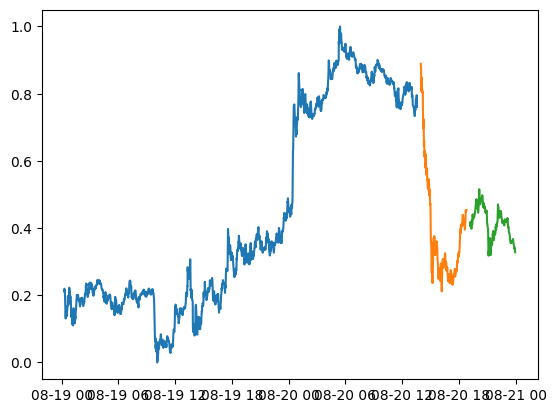

In [ ]:
_ = plt.plot(train_dates, y_train)
_ = plt.plot(valid_dates, y_valid)
_ = plt.plot(test_dates, y_test)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((30, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
tf.debugging.set_log_device_placement(True)

In [ ]:
with tf.device('/gpu:0'):

  model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, callbacks=[cp1])

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.3420 - root_mean_squared_error: 0.5837 - val_loss: 0.2846 - val_root_mean_squared_error: 0.5335
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2843 - root_mean_squared_error: 0.5323 - val_loss: 0.1575 - val_root_mean_squared_error: 0.3969
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2449 - root_mean_squared_error: 0.4944 - val_loss: 0.1282 - val_root_mean_squared_error: 0.3580
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1967 - root_mean_squared_error: 0.4434 - val_loss: 0.1020 - val_root_mean_squared_error: 0.3194
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1303 - root_mean_squared_error: 0.3599 - val_loss: 0.0569 - val_root_mean_squared_error: 0.2386
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0779 - root_mean_squared_error: 0.2789 - val_loss: 0.0485 - val_root_mean_squared_error: 0.2201
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: